# Praxis - Loss Functions mit Imagenette

In diesem Notebook werden verschiedene Loss Functions (Mean Squared Error und Sparse Categorcal Crossentropy) anhand des Imagenette Datensatzes verglichen.



## Imports

In [5]:
%tensorflow_version 2.x # Befehl für Google Colab für Tensorflow 2

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # Befehl für Google Colab für Tensorflow 2`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [6]:
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


### Hier werden alle benötigten Keras Klassen importiert, sowie weitere Packages, die für die Ausführung benötigt werden

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Activation, Input, \
  Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# jupyters notebook Befehl zum direkten Anzeigen von Matplotlib Diagrammen
%matplotlib inline

## Helpers

## Über das `deeplearning2020` python package stellen wir euch folgende helper Funktionen zur Verfügung:

- def plot_learning_curve(title, x, y, y_test, ylim=0.6)
- def plot_history(title, history, ylim=0.6)
- def plot_images(images, labels)

## Zur Nutzung der Funktionen geht ihr folgendermaßen vor:

In [0]:
# Importieren der Helper Function
!pip install --upgrade deeplearning2020

from deeplearning2020 import helpers

#helpers.plot_images(image, class_labels)

Requirement already up-to-date: deeplearning2020 in /usr/local/lib/python3.6/dist-packages (0.4.8)


## Informationen über den Datensatz 

Über `tfds.load` kann man sich neben dem Datensatz selbst auch Informationen über diesen anzeigen 

In [8]:
# Herunterladen des Datensatzes
data, info = tfds.load(
    "imagenette/320px",
    as_supervised=True,
    with_info=True
)

# Größe des Trainingsdatensatzes
dataset_size = info.splits['train'].num_examples

# Größe des Validierungsdatensatzes
dataset_size_val = info.splits['validation'].num_examples


print('dataset size: ', dataset_size)
print('dataset size val: ', dataset_size_val)

# Informationen über die Klassennamen und Anzahl der Klassen
class_names = info.features['label'].names
print('class names: ', class_names)
n_classes = info.features['label'].num_classes
print('number of classes: ', n_classes)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/imagenette/320px/0.1.0.incomplete71I3R8/imagenette-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imagenette/320px/0.1.0.incomplete71I3R8/imagenette-validation.tfrecord


Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/320px/0.1.0. Subsequent calls will reuse this data.
dataset size:  12894
dataset size val:  500
class names:  ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']
number of classes:  10


Über unsere Helper Funktion kann sich der Datensatz angeschaut werden. Dies ist sinnvoll, um einen Überblick über die vorhandenen Daten zu erhalten. Des Weiteren kann man damit Probleme erkennen, zum Beispiel wenn die Bilder nicht korrekt geladen wurden.

Falls die Daten schon preprocessed wurden (siehe unten) muss `train_data.unbatch().take(9)` aufgerufen werden.

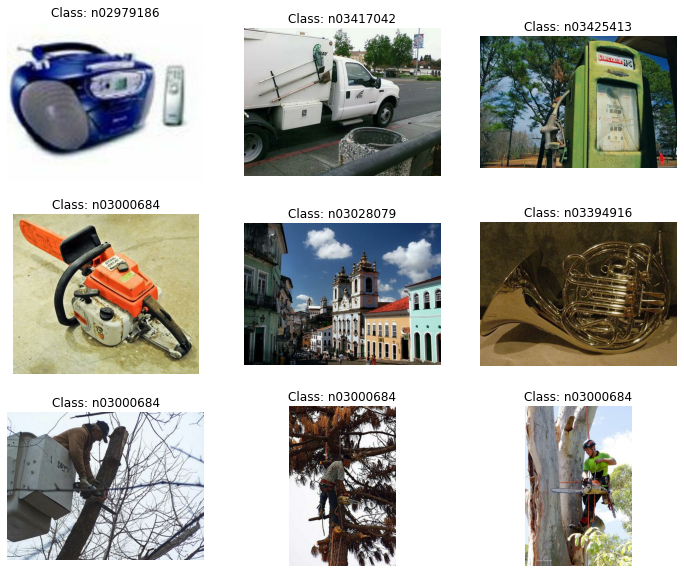

In [0]:
# Anzeigen von 9 Bildern aus dem Trainigsdatensatz
helpers.plot_images(data['train'].take(9), class_names)

## Preprocessing der Daten

#### Um mit den Bilddaten arbeiten zu können, müssen diese eine einheitliche Größe haben. Dafür stellen wir euch die Funktion `preprocess` bereit, die alle Bilder in die vorgegebene Größe umwandelt

Das `tf.one_hot` erstellt beim Preprocessing categorical labels, da wir diese später benötigen


In [0]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [300, 300])
    return resized_image, tf.one_hot(label, 10)

### Laden des Datensatzes


In [0]:
train_data = tfds.load(
    'imagenette/320px',
    split=tfds.Split.TRAIN,
    as_supervised=True
)
test_data = tfds.load(
    'imagenette/320px',
    split=tfds.Split.VALIDATION,
    as_supervised=True
)

# Natürlich lassen sich auf die Trainings und Validation Daten auch über die Variable `data` laden
# Dies kann über data['validation'] und data['train'] passieren.
# Um den Code unabhängig von oben nutzen zu können wurde dies hier noch einmal aufgeführt.

## Vorbereitung der Daten zur schnelleren Verarbeitung
Anwendung der `preprocess` Funktion auf alle Daten

`.batch` bereitet den nächsten Batch mit festeglegter Größe vor

`.prefetch` lädt den nächsten Batch schon in den Speicher


In [11]:
# Festlegung der Batch Größe für die Datenvorbereitung
batch_size = 32 

# Durchmischen der Trainingsdaten, dass nicht mit sortierten Bildern trainiert wird 

train_data = train_data.shuffle(1000) 

print('shape des Trainigsdatensatzes vor dem preprocessing: ', train_data)

train_data = train_data.map(preprocess) \
  .batch(batch_size).prefetch(1)          
test_data = test_data.map(preprocess) \
  .batch(batch_size).prefetch(1)

print('shape des Traingingsdatensatzes nach dem preprocessing: ', train_data)

shape des Trainigsdatensatzes vor dem preprocessing:  <DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
shape des Traingingsdatensatzes nach dem preprocessing:  <DatasetV1Adapter shapes: ((None, 300, 300, 3), (None, 10)), types: (tf.float32, tf.float32)>


# Aufbau des Netzes

Das gleiche, wie im Video zu komplexen Neuronalen Netzen

In [0]:
# model
learning_rate=0.00001
momentum=0.9

def get_model():
  dense_neurons=1000
  n_filters=512
  first_kernel_size=(7,7)

  activation='elu'

  # Inputgröße muss 300x300 Pixel mit 3 RGB Farben betragen
  input_layer = Input(shape=(300, 300, 3))

  # Convolutional Neural Network
  # 6 Convolutional Layers mit jeweils einer Max Pooling Layer
  model = Conv2D(
      filters=256,
      kernel_size=(7,7),
      activation=activation
  )(input_layer)
  model = MaxPooling2D((2,2))(model)

  model = Conv2D(
      filters = 256, 
      kernel_size=(3,3), 
      activation=activation
  )(model)
  model = MaxPooling2D((2,2))(model)

  model = Conv2D(
      filters = n_filters, 
      kernel_size=(3,3), 
      activation=activation
  )(model)
  model = MaxPooling2D((2,2))(model)

  model = Conv2D(
      filters = n_filters, 
      kernel_size=(3,3), 
      activation=activation
  )(model)
  model = MaxPooling2D((2,2))(model)

  model = Conv2D(
      filters = n_filters, 
      kernel_size=(3,3), 
      activation=activation
  )(model)
  model = MaxPooling2D((2,2))(model)

  model = Conv2D(filters = n_filters, 
    kernel_size=(3,3), 
    activation=activation, 
    padding='same'
  )(model)
  model = MaxPooling2D((2,2))(model)

  # Fully-Connected-Classifier
  model = Flatten()(model)
  model = Dense(
      dense_neurons,
      activation=activation
  )(model)

  model = Dense(
      dense_neurons / 2,
      activation='tanh'
  )(model)

  # Output Layer
  output = Dense(n_classes, activation="softmax")(model)
  return Model(input_layer, output)

### Erstellung zweier Modelle mit Mean Squared Error und Sparse Categorcal Crossentropy als Loss Functions 

In [14]:
model_categorical_crossentropy = get_model()

# Kompilieren des Modells
optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=momentum)
model_categorical_crossentropy.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)
model_categorical_crossentropy.summary()

model_mean_squared_error = get_model()

# Kompilieren des Modells
optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=momentum)
model_mean_squared_error.compile(
    loss="mean_squared_error",
    optimizer=optimizer,
    metrics=["accuracy"]
)
model_mean_squared_error.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 294, 294, 256)     37888     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 147, 147, 256)     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 145, 145, 256)     590080    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 72, 72, 256)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 70, 70, 512)       1180160   
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 35, 35, 512)       0   

In [15]:
# Trainieren der Modelle
history_mse = model_mean_squared_error.fit(
    train_data,
    epochs=12,
    validation_data=test_data
)
history_cce = model_categorical_crossentropy.fit(
    train_data,
    epochs=12,
    validation_data=test_data
)

Epoch 1/12
403/403 [==============================] - 158s 392ms/step - loss: 0.0931 - accuracy: 0.1362 - val_loss: 0.0906 - val_accuracy: 0.1980
Epoch 2/12
403/403 [==============================] - 155s 384ms/step - loss: 0.0890 - accuracy: 0.2023 - val_loss: 0.0878 - val_accuracy: 0.2260
Epoch 3/12
403/403 [==============================] - 155s 384ms/step - loss: 0.0871 - accuracy: 0.2369 - val_loss: 0.0860 - val_accuracy: 0.2440
Epoch 4/12
403/403 [==============================] - 155s 384ms/step - loss: 0.0858 - accuracy: 0.2546 - val_loss: 0.0847 - val_accuracy: 0.2680
Epoch 5/12
403/403 [==============================] - 155s 384ms/step - loss: 0.0847 - accuracy: 0.2740 - val_loss: 0.0836 - val_accuracy: 0.2840
Epoch 6/12
403/403 [==============================] - 155s 384ms/step - loss: 0.0839 - accuracy: 0.2877 - val_loss: 0.0827 - val_accuracy: 0.2860
Epoch 7/12
403/403 [==============================] - 155s 384ms/step - loss: 0.0831 - accuracy: 0.3008 - val_loss: 0.0818 -

## Ergebnisse:

Hier sieht man beide Loss Functions im Vergleich

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

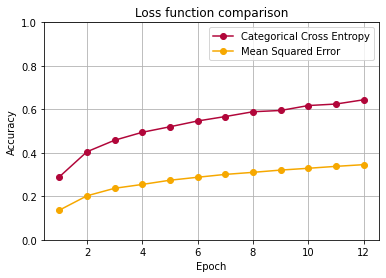

In [17]:
def plot_learning_curve(ylim=0.6):
    plt.figure()
    plt.title("Loss function comparison")
    axes = plt.gca()
    axes.set_ylim([ylim, 1])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    train_sizes = np.arange(1, 1 + len(history_cce.history['accuracy']))
    plt.ylim((0,1))
    plt.grid()
    plt.plot(train_sizes, history_cce.history['accuracy'], 'o-', color=(177/255, 6/255, 58/255),
             label="Categorical Cross Entropy")
    plt.plot(train_sizes, history_mse.history['accuracy'], 'o-', color=(246/255, 168/255, 0),
             label="Mean Squared Error")

    plt.legend(loc="best")
    return plt

plot_learning_curve()